# 뉴럴넷 학습 방법

## MNIST 손글씨 숫자 인식 학습

이미 학습된 매개변수를 사용하여 학습과정은 생략하고 추론과정부터 구현해본다.

MNIST 데이터넷은 0~9까지 손글씨 훈련이미지 6만장, 시험이미지 1만장이 준비되어있다.

28 * 28 크기 회색조 이미지이며, 각 픽셀은 0~255까지 값을 취한다. 또한 레이블도 포함되어있다.

MNIST 파일은 웹사이트(https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/tutorials/mnist) 에서 다운받을 수 있다.

In [1]:
import sys, os
sys.path.append(os.pardir) # 부모 디렉터리 파일을 가져올 수 있도록 설정한다.
from dataset.mnist import load_mnist # mnist 데이터셋을 불러온다.
from PIL import Image # 프롬프트에서 pip install image로 설치
import pickle

import numpy as np
import matplotlib.pylab as plt

### 데이터셋 로드

In [2]:
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=True, normalize=False)

normalize는 0.0~1.0사이 값으로 정규화 할지를 정한다(안할 경우 0~255)

flatten 입력이미지를 평탄하게(1차원) 만들지 정한다. 안할 경우 1 * 28 * 28 3차원배열로 true로하면 784개의 원소로 이루어진 1차원 배열로 저장한다.

one_hot_label은 레이블을 원-핫-인코딩형태로 저장할지 정한다. false일 경우 숫자형태 레이블로 저장한다.

각 데이터셋의 형태는 다음과 같다.

In [3]:
print(x_train.shape)
print(t_train.shape)
print(x_test.shape)
print(t_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


파이썬의 pickle 기능으로 프로그램 실행중 특정 객체를 파일로 저장한다. 저장한 pickle 파일을 로드하면 실행 당시의 객체를 즉시 복원할 수 있다.

load_mnist()함수도 2번째 읽을 때 pickle을 이용하여 빠르게 준비할 수 있다.

### 로드 이미지 출력

간단한 함수로 불러온 데이터셋의 이미지를 출력해본다.

In [4]:
def img_show(img):
    pil_img = Image.fromarray(np.uint8(img)) # np로 저장된 이미지 데이터를 pil용 데이터 객체로 변환
    pil_img.show()
    
(x_train, t_train), (x_test, t_test) = \
    load_mnist(flatten=True, normalize=False)

img = x_train[0]
label = t_train[0]
print(label)

print(img.shape)
img = img.reshape(28,28) # 1차원 배열로 받아온 이미지를 28*28 이미지로 다시 변환
print(img.shape)

img_show(img)

5
(784,)
(28, 28)


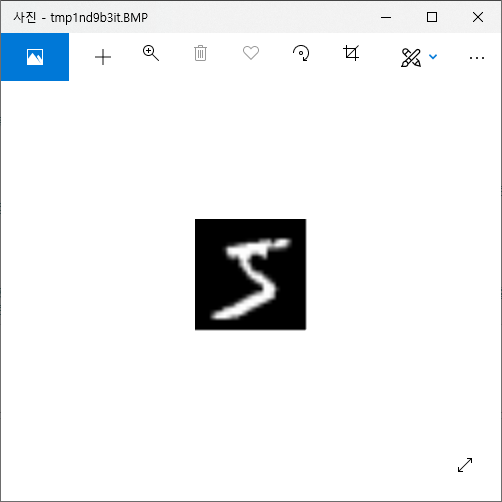

### 뉴럴넷 추론

설계할 뉴럴넷의 입력은 784개(28*28 이미지), 출력은 10개(0~9 숫자)이다.

은닉층은 2개이며 1층(50뉴런)과 2층(100뉴런)으로 구성된다. 각각의 뉴런수는 임의로 지정하였다.

작업에 사용될 함수는 다음과 같다.

#### 데이터를 받아오는 함수

In [5]:
def get_data():
    (x_train, t_train), (x_test, t_test) = load_mnist(flatten=True, normalize=False, one_hot_label=False)
    return x_test, t_test

####  학습된 네트워크를 불러오는 함수

In [6]:
def init_network(): 
    with open("dataset/sample_weight.pkl", 'rb') as f: # sample_weight.pkl 파일에 저장된 학습된 가중치 매개변수를 불러온다.(딕셔너리 변수로 저장)
        network = pickle.load(f) # 학습된 네트워크를 불러와 사용
                
    return network

#### 뉴럴넷 함수

In [7]:
def sigmoid(x):
    return 1 / (1+np.exp(-x)) # 시그모이드 함수 공식으로 쉽게 구현 가능하다.
# 넘파이 브로드캐스트 기능으로 배열과 스칼라값의 연산을 넘파이 배열의 원소 각각과 스칼라값의 연산으로 바꿔 수행해준다.

x = np.arange(-5.0, 5.0, 0.1)
y = sigmoid(x)

def softmax(a):
    c = np.max(a)
    exp_a = np.exp(a-c) # 최대값 c를 빼서 오버플로우를 막는다.
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    
    return y

#### 예측 함수

In [9]:
def predict(network, x): 
    # 각 네트워크 뉴런의 weight, bias를 불러옴
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']
    
    # 각 네트워크를 연결
    a1 = np.dot(x, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    z2 = sigmoid(a2)
    a3 = np.dot(z2, W3) + b3
    y = softmax(a3)
    
    return y

#### 학습 및 결과

In [10]:
x, t = get_data() # x와 t에 테스트 바일을 받아옴
network = init_network() # 네트워크를 받아옴

accuracy_cnt = 0 # 정확도를 표시할 변수
for i in range(len(x)): # x에서 이미지를 한장씩 꺼내 predict 함수로 분류한다. 각 레이블의 확률이 넘파이 배열로 반환된다.
    y = predict(network, x[i]) 
    p = np.argmax(y)  # 가장 높은 확률을 갖는 원소 인덱스를 얻어옴(argmax)
    if p == t[i]: # 예측한 답변과 정답 레이블을 비교한다(t[i]는 정답레이블) 
        accuracy_cnt += 1 # 맞힌 숫자를 센다
        
print("Accuracy:" + str(float(accuracy_cnt) / len(x))) # 맞힌 숫자/전체수로 정확도를 구한다.

D:\_setup\anaconda3\envs\py3.7\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Accuracy:0.9207


## 배치 (Batch)

배치란 하나로 묶은 입력 데이터를 말한다. 100 * 784 배치의 경우 출력으로 100 * 10 이 나오게 된다.

배치를 사용하면 이미지 1장당 처리시간을 대폭 줄일 수 있다.

커다란 뉴럴넷에서는 데이터 병목현상이 일어날 수 있는데 배치처리를 통해 버스에 주는 부하를 줄일 수 있다.

컴퓨터는 큰 배열을 한번에 계산하는 것이 작은 배열을 여러번 계산하는것 보다 빠르다.

In [11]:
x, t = get_data()
network = init_network()

batch_size = 100 # 배치 크기를 정함.
accuracy_cnt = 0

for i in range(0, len(x), batch_size): # 0부터 x 길이까지 배치사이즈 간격으로
    x_batch = x[i:i+batch_size] # 반환되는 리스트를 기준으로 입력 데이터를 묶는다. i부터 i+배치크기 까지(100장씩 묶임)
    y_batch = predict(network, x_batch) # 묶인 x배치를 예측함수에 넣어 y배치로 출력받음
    p = np.argmax(y_batch, axis=1) # 최대값 인덱스를 가져온다. axis=1은 100*10 배열중 1번째 차원을 구성하는 각 원소에서 최대값을 찾게함.
    accuracy_cnt += np.sum(p==t[i:i+batch_size]) # ==연산자로 결과와 답을 비교하고 bool 배열로 만든 뒤 true의 개수를 센다.
    
print("Accuracy:" + str(float(accuracy_cnt)/len(x)))

Accuracy:0.9207


D:\_setup\anaconda3\envs\py3.7\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


## 미니 배치 (Mini Batch)

미니 배치는 많은 양의 데이터를 학습 할때, 전체 데이터 중 일부를 잘라 학습할 때 사용된다.

미니배치는 Iteratiom이 한번 수행될 때 소요되는 시간이 매우 짧으며, 비용 함수(cost function)의 최적값을 찾는 속도가 매우 빠르다.

다만 데이터 전체의 경향을 반영하기 힘들고 반드시 좋은 방향으로 학습이 업데이트 되지는 않는다. 배치와 미니배치는 상황에 따라 선택하여 사용하는 것이 좋다.

마찬가지로 MNIST 데이터셋을 사용하여 미니 배치를 구현한다.

### 데이터셋 로드

In [12]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True) # 원핫키로 정답 위치만 1이고 나머지는 0으로 받아옴

print(x_train.shape) # 입력 784
print(t_train.shape) # 출력 10

(60000, 784)
(60000, 10)


### 미니 배치 설계

무작위의 데이터 10장을 가져오는 미니배치를 설계한다.

In [13]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size) # np.rndom.choice(원본 값, 가져올 값)으로 데이터를 불러온다.
print(batch_mask) # 인덱스를 얻을 수 있다.
x_batch = x_train[batch_mask] # 무작위 값을 인덱스로 사용하여 train 데이터에서 batch값을 불러온다.
t_batch = t_train[batch_mask]

[48998 10630 22514 18152 31217  4629  8054 14077  7372 44268]


### 미니 배치 CEE

배치 데이터에 사용할 CEE를 만든다.

기존에 설계한 CEE에서 데이터가 배치로 묶여 입력될 경우 모두를 처리하도록 변경한다.

In [14]:
def CEE(y, t):
    delta = 1e-7 # 매우작은값 델타. 0이되는것을 막는다.
    if y.ndim == 1: # y는 신경망의 출력, t는 정답레이블로 y가 1차원이면 데이터 하나당 교차엔트로피 오차를 구하는경우 reshape로 형상을 바꾼다.
        t = t.reshape(1, t.size)
        y = y.reshape(1,y.size)
        
    batch_size = y.shape[0] # 배치 크기는 받ㄴ아온 y의 shape의 첫번째 요소에서 받아올 수 있다.
    return -np.sum(t*np.log(y + delta)) / batch_size # CEE 함수를 모두 더한뒤 batch_size로 나누어 평균 CEE를 구한다.

만일 정답 레이블이 원핫 인코딩이 아닌 숫자레이블로 주어졌을때는 다음과 같이 설계할 수 있다.

이 구현에서는 원핫 인코딩시 정답에 해당하는 신경망의 출력만으로 교차엔트로피 오차를 구할 수 있으므로 t*np.log(y)였던 부분을 레이블 표현 시 np.log(y[np.arrange(batch_size),t])로 구현한다.

이는 0부터 batch_size-1 까지 배열을 생성하고, t에는 레이블이 저장되어있으므로 각 데이터의 정답에 해당하는 신경망의 출력을 추출한다.

결과 [y[0,2], y[1,7], ...] 인 넘파이 배열을 생성한다.

In [15]:
def CEE2(y,t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1,y.size)
        
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

### 경사하강법

최소값을 찾는 방법.

현 위치에서 기울어진 방향으로 일정거리를 이동한뒤 이동한곳에서 다시 기울기를 구하고 기울어진 방향으로 나아가는것을 반복한다.

이 과정을 반복하여 함수의 값을 점차줄여 함수를 최적화(Optimizer)한다.

이때 학습률과 같은 매개변수를 하이퍼 파라메터라 하며, 가중치, 편향같은 자동으로 정해지는 신경망의 매개변수와 달리 사람이 직접 정해줘야 하는 값을 말한다.

In [16]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x # 초기값 x
    
    for i in range(step_num): # 경사법 반복 횟수: 100회
        grad = numerical_gradient(f,x) # 함수기울기는 numerical_gradient 함수를 사용한다.
        x -= lr * grad # lr은 learning rate(학습률)
        
    return x

### 기울기 (Gradient)

뉴럴넷의 기울기는 가중치 매개변수에 대한 손실함수의 기울기를 말한다.

In [20]:
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient

class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3) # 정규분포로 랜덤한 weight W를 생성
        
    def predict(self, x):
        return np.dot(x, self.W) # 예측함수로 x와 W를 dot product 한다.
    
    def loss(self, x, t):
        z = self.predict(x) # 예측함수 동작
        y = softmax(z) # 소프트맥스함수로 노멀라이즈
        loss = cross_entropy_error(y, t) # CEE로 오차산출 최소값을 구한다. t는 정답 레이블
        
        return loss
    
net = simpleNet()
print("weight: ", net.W)

x = np.array([0.6, 0.9])
p = net.predict(x)
print("predict: ", p)
print(np.argmax(p))

t = np.array([0,0,1]) # 정답 레이블
print("Loss: ", net.loss(x,t))

weight:  [[ 0.96884702  0.32898188 -0.44237715]
 [ 0.87663749  0.90464042 -0.33052527]]
predict:  [ 1.37028195  1.01156551 -0.56289903]
0
Loss:  2.5447152502946944


기울기는 다음과 같다.

In [21]:
def f(W):
    return net.loss(x,t) # 이 함수의 인수 W는 더미로 만든것이며 NG 내부에서 f(x)를 실행하는데 일관성을 위해 f(W)를 정의했다.
# f = lambda w: net.loss(x,t) # 람다 표현식을 사용할 수도 있다.
dW = numerical_gradient(f, net.W)
print(dW)

[[ 0.32550989  0.22739223 -0.55290212]
 [ 0.48826483  0.34108834 -0.82935317]]


### 학습 알고리즘 구현

학습 절차는 다음과 같다.
    
    1. 미니 배치
    2. 기울기 산출
    3. 매개변수 갱신
    4. 1~3 반복

미니 배치를 무작위로 선정 하는 방법을 확률적 경사하강법 Stochastic gradient descent(SGD)라고 하며 대부분의 딥러닝 프레임워크가 이 기능을 구현하고 있다.

MNIST 데이터셋을 이용한 2층 신경망을 설계한다.

In [18]:
from common.functions import *
from common.gradient import numerical_gradient

#### 2층 신경망

In [19]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01): 
        # 각 가중치를 초기화한다.
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size) # input을 받고 hidden_size만큼 출력
        self.params['b1'] = np.zeros(hidden_size) # hidden_size만큼 곱해짐
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) # hidden_size만큼 받고 output_size만큼 출력
        self.params['b2'] = np.zeros(output_size) # output_size만큼 받는다.
        
        # params 변수는 가중치 매개변수가 저장된다. 1번 층의 가중치 매개변수는 params['W1']키에 넘파이 배열로 저장된다.
        # mnist는 28*28이미지를 사용하며 출력이 0~9이므로 input 784, output 10을 사용한다.
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2'] # 각각의 파라메터를 받아옴
        
        a1 = np.dot(x, W1) + b1 # 각 레이어를 연결
        z1 = sigmoid(a1) # a의 출력을 활성화함수를 통과시켜 최종값 z를 만든다
        a2 = np.dot(z1, W2) +b2
        z2 = sigmoid(a2)
        y = softmax(a2) # 최종 값을 softmax에 통과시켜 normalize 한다.
        
        return y
    # params 변수에 저장된 가중치 매개변수는 여기에서 사용된다.
    
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t) # 예측 메서드를 통과한 값에서 CEE로 오차 구함
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis = 1) # y에 예측값을 받아온뒤 argmax값을 구한다.
        t = np.argmax(t, axis = 1) # t에서 정답을 받아온다.
        
        accuracy = np.sum(y == t) / float(x.shape[0]) # y와 t가 동일한 값의 총합을 구한뒤 x의 크기로 나누어 정확도 평균을 구한다.
        return accuracy
    
    # x는 입력데이터이며 t는 정답 레이블이다.
    # 여기서 back propagation을 수행한다.
    def numerical_gradient(self, x, t): # 가중치 매개변수의 기울기를 구한다.
        loss_W = lambda W: self.loss(x,t) # gradient(f,x) 내부에서 f(x)가 실행할때의 일관성을위한 더미W이며 실제 값은 x, t의 loss값이다.
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
    # grads 변수에는 params 변수에 대응하는 각 매개변수의 기울기를 저장한다. numerical_gradient 함수를 동작하면 기울기가 계산되며
    # 해당 기울기는 grads[]의 각 요소에 refresh된다.

In [ ]:
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(iters_num,loss)
plt.show()

### 미니 배치 학습 및 시험 데이터 평가

학습 도중 정기적으로 훈련 데이터와 시험 데이터를 대상으로 정확도를 기록한다.

1에폭(epoch) 단위로 훈련데이터와 시험데이터에 대한 정확도를 기록한다. 1에폭 = 훈련데이터 / 미니배치

학습 시간이 오래 걸리므로 충분한 시간을 갖고 학습을 진행한다.       

In [ ]:
# 하이퍼파라메터 지정
iters_num = 1000 # 반복횟수
train_size = x_train.shape[0] 
batch_size = 100 # 미니배치 크기 지정
learning_rate = 0.1 # 학습률

network = TwoLayerNet(input_size = 784, hidden_size = 50, output_size = 10) # 네트워크를 불러옴. 히든레이어 사이즈는 50으로 지정

train_loss_list = []
train_acc_list = [] # 훈련 데이터 평가
test_acc_list = [] # 테스트 데이터 평가

iter_per_epoch = max(train_size / batch_size, 1) # 1에폭 당 반복수


for i in range(iters_num): # 반복횟수만큼 시행
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    grad = network.numerical_gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key] # 네트워크 키를 학습률을 곱한값만큼 이동시켜 갱신한다.
        
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train) # 1에폭마다 모든 훈련데이터와 시험데이터에 대한 정확도를 계산한다.
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc) # 훈련데이터와 시험데이터에 대한 정확도를 리스트에 저장한다.
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + "," +str(test_acc)) # 정확도를 출력한다.
        # 1에폭마다 정확도를 계산하는 이유는 for문 안에서 매번 계산하기에는 시간이 오래걸리고 자주 기록할 필요도 없기 때문이다.

train acc, test acc | 0.09736666666666667,0.0982


In [ ]:
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(iters_num,loss)
plt.show()